In [1]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
import numpy as np 
from torch.optim import Adam 
import matplotlib.pyplot as plt 
import torch

/data/u_kamm_software/EEG data analysis/eeg_llm/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# generate noisy sine and cosine waves as toy data
def generate_wave_data(num_samples=1000, seq_length=100):
    t = np.linspace(0, 4*np.pi, seq_length)
    sine = np.sin(t) + 0.1 * np.random.randn(seq_length)
    cosine = np.cos(t) + 0.1 * np.random.randn(seq_length)

    data = np.stack([sine, cosine], axis=1)


    return data

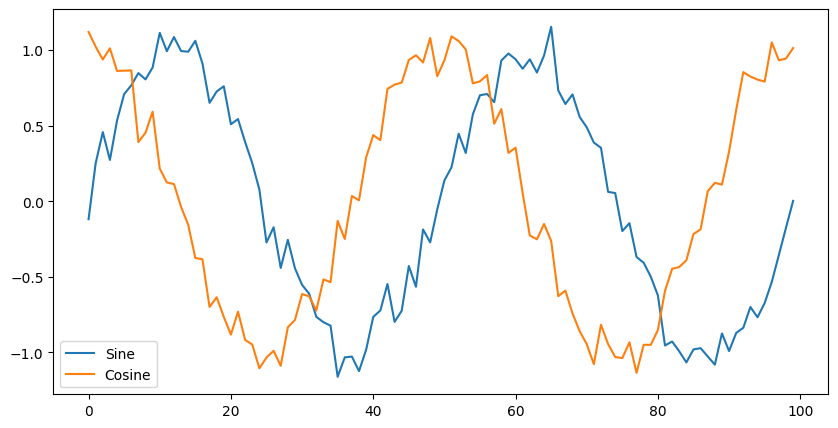

In [3]:
# plot the toy data 
data = generate_wave_data()

plt.figure(figsize=(10, 5))
plt.plot(data[:, 0], label="Sine")
plt.plot(data[:, 1], label="Cosine")
plt.legend()
plt.show()

In [4]:
# divide in past and future values for training the transformer 
past_values = torch.tensor(data[:-10], dtype=torch.float32)
future_values = torch.tensor(data[-10:], dtype=torch.float32)

In [5]:
# define the configuration of the model 
config = TimeSeriesTransformerConfig(
    prediction_length=10,  # length of the future values to predict
    context_length=90,  # length of the past values to use
    num_time_features=1,
    num_dynamic_real_features=2,  # the number of time features (here we have only time steps)
    encoder_layers=2,  # number of transformer layers in the encoder
    decoder_layers=2,  # number of transformer layers in the decoder
    d_model=32,  # dimension of the model
    n_heads=4,  # number of attention heads
    lags_sequence=[1, 2, 3, 4], 
    )

# initialize the model 
model = TimeSeriesTransformerForPrediction(config)

In [6]:
# Modified batch with correct dimensions
batch = {
    "past_values": past_values.unsqueeze(0),  # (1, seq_length, 2)
    "future_values": future_values.unsqueeze(0),  # (1, prediction_length, 2)
    "past_time_features": torch.arange(len(past_values)).unsqueeze(0).unsqueeze(2).float(),  # (1, seq_length, 1)
    "past_observed_mask": torch.ones_like(past_values.unsqueeze(0)),  # (1, seq_length, 2)
    "future_time_features": torch.arange(len(past_values), len(past_values) + 10).unsqueeze(0).unsqueeze(2).float(),  # (1, prediction_length, 1)
    # "static_categorical_features": torch.zeros((1, 1), dtype=torch.long),  # Corrected to shape (1, 1)
    # "static_real_features": torch.zeros((1, 1, 2), dtype=torch.float32),  # Corrected to shape (1, 1, 2)
}


In [8]:
batch["past_time_features"].shape

torch.Size([1, 90, 1])

In [9]:
# Initialize optimizer
optim = Adam(model.parameters(), lr=1e-3)

# Define training loop 
num_epochs = 100 

for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(
        past_values=batch["past_values"],
        past_time_features=batch["past_time_features"],
        past_observed_mask=batch["past_observed_mask"],
        # static_categorical_features=batch["static_categorical_features"],
        # static_real_features=batch["static_real_features"],
        future_values=batch["future_values"],
        future_time_features=batch["future_time_features"],
    )

    loss = outputs.loss

    # Backward pass
    optim.zero_grad()
    loss.backward()
    optim.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

RuntimeError: expand(torch.FloatTensor{[1, 1, 2, 2]}, size=[-1, 96, -1]): the number of sizes provided (3) must be greater or equal to the number of dimensions in the tensor (4)